<a href="https://colab.research.google.com/github/petyaslavkova/Bachelorarbeit/blob/main/GANSimpsons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
##Test

##Inserting  CycleGAN


In [7]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2337, done.
remote: Total 2337 (delta 0), reused 0 (delta 0), pack-reused 2337
Receiving objects: 100% (2337/2337), 8.09 MiB | 36.02 MiB/s, done.
Resolving deltas: 100% (1499/1499), done.


In [8]:
import os
os.chdir('pytorch-CycleGAN-and-pix2pix/')

In [10]:
!pip install -r requirements.txt

     |████████████████████████████████| 686kB 6.6MB/s 
     |████████████████████████████████| 61kB 7.0MB/s 
  Created wheel for visdom: filename=visdom-0.1.8.9-cp37-none-any.whl size=655251 sha256=60754288e9a6300a0d86b3bdd3ba9044c223315b04b8e0b58b825fff9ba22f9a
  Stored in directory: /root/.cache/pip/wheels/70/19/a7/6d589ed967f4dfefd33bc166d081257bd4ed0cb618dccfd62a
  Created wheel for torchfile: filename=torchfile-0.1.0-cp37-none-any.whl size=5713 sha256=6b882a314c2e691d0d908dd729bfc13326b6ff2c4ece4e2162ffec533b583b5b
  Stored in directory: /root/.cache/pip/wheels/b1/c3/d6/9a1cc8f3a99a0fc1124cae20153f36af59a6e683daca0a0814
Successfully built visdom torchfile


##Datasets

In [11]:
from pathlib import Path
from fastai import *
import glob
from fastai.vision import *

TRAIN_A_NAME = 'simpsons_faces'
TRAIN_B_NAME = 'human_face'
DATASET = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME)
TRAIN_A = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME+'/trainA')
TRAIN_B = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME+'/trainB')
TEST_A = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME+'/testA')
TEST_B = Path('/content/pytorch-CycleGAN-and-pix2pix/datasets/'+TRAIN_A_NAME+'/testB')
URLS_FILE = 'urls.txt'

!rm -Rf $DATASET
os.makedirs(DATASET, exist_ok = True)
os.makedirs(TRAIN_A, exist_ok = True)
os.makedirs(TRAIN_B, exist_ok = True)
os.makedirs(TEST_A, exist_ok = True)
os.makedirs(TEST_B, exist_ok = True)


##Download Simpsons Faceset

In [12]:
! pip install -q kaggle

from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"petyaslavkova5","key":"a7a4ff467a8c79cbb106700bd7d80e25"}'}

In [13]:
! mkdir ~/.kaggle

! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              222KB  2021-04-05 06:19:09           1830  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44           1179  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            909  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19            414  
promptcloud/care

In [14]:

def create_training_dataset_simpson_faces(download_dir):

  %cd $download_dir

  # download dataset and unzip
  !kaggle datasets download kostastokis/simpsons-faces --force
  !unzip \*.zip
  !rm *.zip
  !cp -a $download_dir/cropped/. $download_dir

  # remove unnecessary folders
  !rm -Rf $download_dir/cropped
  !rm -Rf $download_dir/simplified

  # go back to orig directory
  %cd /content/pytorch-CycleGAN-and-pix2pix

create_training_dataset_simpson_faces(TRAIN_A)

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: simplified/539.png      
  inflating: simplified/5390.png     
  inflating: simplified/5391.png     
  inflating: simplified/5392.png     
  inflating: simplified/5393.png     
  inflating: simplified/5394.png     
  inflating: simplified/5395.png     
  inflating: simplified/5396.png     
  inflating: simplified/5397.png     
  inflating: simplified/5398.png     
  inflating: simplified/5399.png     
  inflating: simplified/54.png       
  inflating: simplified/540.png      
  inflating: simplified/5400.png     
  inflating: simplified/5401.png     
  inflating: simplified/5402.png     
  inflating: simplified/5403.png     
  inflating: simplified/5404.png     
  inflating: simplified/5405.png     
  inflating: simplified/5406.png     
  inflating: simplified/5407.png     
  inflating: simplified/5408.png     
  inflating: simplified/5409.png     
  inflating: simplified/541.png      
  inflating: simplifi

##Download Real Faceset 

In [15]:

%cd /content/

%tensorflow_version 1.x
import tensorflow as tf

# Download the code
# !git clone https://github.com/NVlabs/stylegan2.git
!git clone https://github.com/spiyer99/stylegan2
# !pip install tf-nightly-gpu
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run
!nvidia-smi -L

/content
fatal: destination path 'stylegan2' already exists and is not an empty directory.
/content/stylegan2
CPU says hello.
GPU says hello.
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-d365ed5b-1964-d66b-b2cd-bf144cad5bd5)


In [16]:
# Download the model of choice
%cd /content/stylegan2/
import argparse
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio

import pretrained_networks

# Choose between these pretrained models - I think 'f' is the best choice:

# 1024×1024 faces
# stylegan2-ffhq-config-a.pkl
# stylegan2-ffhq-config-b.pkl
# stylegan2-ffhq-config-c.pkl
# stylegan2-ffhq-config-d.pkl
# stylegan2-ffhq-config-e.pkl
# stylegan2-ffhq-config-f.pkl

# 512×384 cars
# stylegan2-car-config-a.pkl
# stylegan2-car-config-b.pkl
# stylegan2-car-config-c.pkl
# stylegan2-car-config-d.pkl
# stylegan2-car-config-e.pkl
# stylegan2-car-config-f.pkl

# 256x256 horses
# stylegan2-horse-config-a.pkl
# stylegan2-horse-config-f.pkl

# 256x256 churches
# stylegan2-church-config-a.pkl
# stylegan2-church-config-f.pkl

# 256x256 cats
# stylegan2-cat-config-f.pkl
# stylegan2-cat-config-a.pkl
network_pkl = "gdrive:networks/stylegan2-ffhq-config-f.pkl"

# If downloads fails, due to 'Google Drive download quota exceeded' you can try downloading manually from your own Google Drive account
# network_pkl = "/content/drive/My Drive/GAN/stylegan2-ffhq-config-f.pkl"

print('Loading networks from "%s"...' % network_pkl)
_G, _D, Gs = pretrained_networks.load_networks(network_pkl)
noise_vars = [var for name, var in Gs.components.synthesis.vars.items() if name.startswith('noise')]

/content/stylegan2
Loading networks from "gdrive:networks/stylegan2-ffhq-config-f.pkl"...


In [3]:
# Useful utility functions...

# Generates a list of images, based on a list of latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_in_w_space(dlatents, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    Gs_kwargs.truncation_psi = truncation_psi
    dlatent_avg = Gs.get_var('dlatent_avg') # [component]

    imgs = []
    for row, dlatent in log_progress(enumerate(dlatents), name = "Generating images"):
        #row_dlatents = (dlatent[np.newaxis] - dlatent_avg) * np.reshape(truncation_psi, [-1, 1, 1]) + dlatent_avg
        dl = (dlatent-dlatent_avg)*truncation_psi   + dlatent_avg
        row_images = Gs.components.synthesis.run(dlatent,  **Gs_kwargs)
        imgs.append(PIL.Image.fromarray(row_images[0], 'RGB'))
    return imgs       

def generate_images(zs, truncation_psi):
    Gs_kwargs = dnnlib.EasyDict()
    Gs_kwargs.output_transform = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)
    Gs_kwargs.randomize_noise = False
    if not isinstance(truncation_psi, list):
        truncation_psi = [truncation_psi] * len(zs)
        
    imgs = []
    for z_idx, z in log_progress(enumerate(zs), size = len(zs), name = "Generating images"):
        Gs_kwargs.truncation_psi = truncation_psi[z_idx]
        noise_rnd = np.random.RandomState(1) # fix noise
        tflib.set_vars({var: noise_rnd.randn(*var.shape.as_list()) for var in noise_vars}) # [height, width]
        images = Gs.run(z, None, **Gs_kwargs) # [minibatch, height, width, channel]
        imgs.append(PIL.Image.fromarray(images[0], 'RGB'))
    return imgs

def generate_zs_from_seeds(seeds):
    zs = []
    for seed_idx, seed in enumerate(seeds):
        rnd = np.random.RandomState(seed)
        z = rnd.randn(1, *Gs.input_shape[1:]) # [minibatch, component]
        zs.append(z)
    return zs

# Generates a list of images, based on a list of seed for latent vectors (Z), and a list (or a single constant) of truncation_psi's.
def generate_images_from_seeds(seeds, truncation_psi):
    return generate_images(generate_zs_from_seeds(seeds), truncation_psi)

def saveImgs(imgs, location):
  for idx, img in log_progress(enumerate(imgs), size = len(imgs), name="Saving images"):
    file = location+ str(idx) + ".png"
    img.save(file)

def imshow(a, format='png', jpeg_fallback=True):
  a = np.asarray(a, dtype=np.uint8)
  str_file = BytesIO()
  PIL.Image.fromarray(a).save(str_file, format)
  im_data = str_file.getvalue()
  try:
    disp = IPython.display.display(IPython.display.Image(im_data))
  except IOError:
    if jpeg_fallback and format != 'jpeg':
      print ('Warning: image was too large to display in format "{}"; '
             'trying jpeg instead.').format(format)
      return imshow(a, format='jpeg')
    else:
      raise
  return disp

def showarray(a, fmt='png'):
    a = np.uint8(a)
    f = StringIO()
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))

        
def clamp(x, minimum, maximum):
    return max(minimum, min(x, maximum))
    
def drawLatent(image,latents,x,y,x2,y2, color=(255,0,0,100)):
  buffer = PIL.Image.new('RGBA', image.size, (0,0,0,0))
   
  draw = ImageDraw.Draw(buffer)
  cy = (y+y2)/2
  draw.rectangle([x,y,x2,y2],fill=(255,255,255,180), outline=(0,0,0,180))
  for i in range(len(latents)):
    mx = x + (x2-x)*(float(i)/len(latents))
    h = (y2-y)*latents[i]*0.1
    h = clamp(h,cy-y2,y2-cy)
    draw.line((mx,cy,mx,cy+h),fill=color)
  return PIL.Image.alpha_composite(image,buffer)
             
  
def createImageGrid(images, scale=0.25, rows=1):
   w,h = images[0].size
   w = int(w*scale)
   h = int(h*scale)
   height = rows*h
   cols = ceil(len(images) / rows)
   width = cols*w
   canvas = PIL.Image.new('RGBA', (width,height), 'white')
   for i,img in enumerate(images):
     img = img.resize((w,h), PIL.Image.ANTIALIAS)
     canvas.paste(img, (w*(i % cols), h*(i // cols))) 
   return canvas

def convertZtoW(latent, truncation_psi=0.7, truncation_cutoff=9):
  dlatent = Gs.components.mapping.run(latent, None) # [seed, layer, component]
  dlatent_avg = Gs.get_var('dlatent_avg') # [component]
  for i in range(truncation_cutoff):
    dlatent[0][i] = (dlatent[0][i]-dlatent_avg)*truncation_psi + dlatent_avg
    
  return dlatent

def interpolate(zs, steps):
   out = []
   for i in range(len(zs)-1):
    for index in range(steps):
     fraction = index/float(steps) 
     out.append(zs[i+1]*fraction + zs[i]*(1-fraction))
   return out

# Taken from https://github.com/alexanderkuk/log-progress
def log_progress(sequence, every=1, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

In [18]:
#stylegan create faceset
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

def create_training_dataset_real_faces_stylegan(download_dir):

  # create in batches of 100
  # reduces RAM requirements
  LIMIT = 10000
  counter = 0
  pbar = tqdm(total = LIMIT)

  while counter < LIMIT:

    seeds = np.random.randint(10000000, size=100)
    imgs = generate_images_from_seeds(seeds, 0.7)

    for img in imgs:
      img.save(download_dir/'real_face_{}.jpg'.format(counter), 'JPEG', quality=100)
      counter+=1
      pbar.update(1)
    del imgs

create_training_dataset_real_faces_stylegan(TRAIN_B)

In [22]:
## Train Test Split 
# move images to a new folder
# `images` is the existing image directory: 
# `new_dir` is the path that the images will be moved to
# `files_limit` is the limit of files that will be moved
def move_all_images_to_new_folder(images, new_dir, files_limit = None):
  files = glob.glob(str(images/'*.*g'))
  
  if(files_limit is not None):
    files = files[:files_limit]

  for file in files: shutil.move(file, new_dir/os.path.basename(file))
LIMIT = 10000
move_all_images_to_new_folder(TRAIN_A, new_dir = TEST_A, files_limit = int(min(LIMIT*0.1, 25)))
move_all_images_to_new_folder(TRAIN_B, new_dir = TEST_B, files_limit = int(min(LIMIT*0.1, 25)))

9852 imgs in TRAIN_A directory


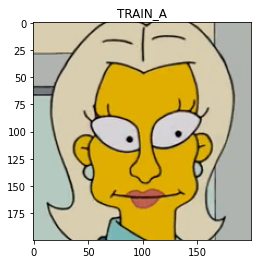

9975 imgs in TRAIN_B directory


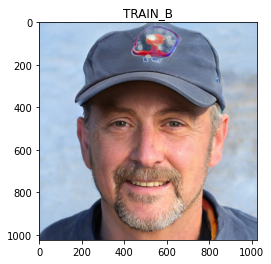

25 imgs in TEST_A directory


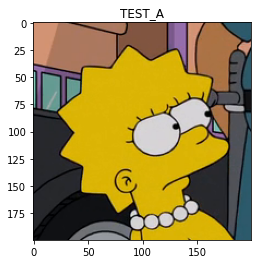

25 imgs in TEST_B directory


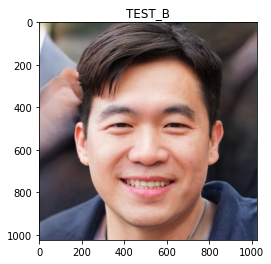

In [23]:
## See Training and Testing Data 
import PIL
import random

def plot_from_image_path(path, title):

  all_imgs = glob.glob(str(path/'*.*g'))

  print(f'{len(all_imgs)} imgs in {title} directory')

  img_path = random.choice(all_imgs)
  img = PIL.Image.open(img_path)
  plt.imshow(img)
  plt.title(title)
  plt.show()

plot_from_image_path(TRAIN_A, 'TRAIN_A')
plot_from_image_path(TRAIN_B, 'TRAIN_B')

plot_from_image_path(TEST_A, 'TEST_A')
plot_from_image_path(TEST_B, 'TEST_B')

#Creating the model

In [24]:
%cd /content/pytorch-CycleGAN-and-pix2pix

/content/pytorch-CycleGAN-and-pix2pix


In [25]:

import gc; gc.collect()
NAME = 'person2simpson'
BATCH_SIZE = 2

In [26]:
import os
from pathlib import Path
from distutils.dir_util import copy_tree
import matplotlib.pyplot as plt
import random

def copy_to_drive(folder = 'cyclegan_simpsonify'):

  drive_folder = Path('/content/drive/My Drive/')/folder

  if(drive_folder.exists()):
    shutil.rmtree(drive_folder)

  shutil.copytree('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/', str(drive_folder))

def get_corresponding_photo(file_path):
  return file_path.replace('fake', 'real')

def plot_results(number):

  for i in range(number):

    img_path = random.choice(glob.glob('./results/'+NAME+'/test_latest/images/*fake.*g'))
    print(img_path)
    img = plt.imread(img_path)
    plt.imshow(img)
    plt.title('fake')
    plt.show()

    print(get_corresponding_photo(img_path))
    img = plt.imread(get_corresponding_photo(img_path))
    plt.imshow(img)
    plt.title('real')
    plt.show()

def get_model(src, dst):

  # copy across model
  try:
    os.remove(dst)
  except:
    pass
  shutil.copyfile(src, dst)

def copy_from_drive(folder = 'cyclegan_simpsonify'):

  drive_folder = Path('/content/drive/My Drive/')/folder

  if(not Path('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/').exists()): 
    os.mkdir('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/')

  if(Path('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/').exists()): 
    shutil.rmtree('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/')

  shutil.copytree(str(drive_folder), '/content/pytorch-CycleGAN-and-pix2pix/checkpoints/'+NAME+'/')

def test_model (number_results = 5, direction = 'BtoA', src = None, dst = None):

  # delete results folder and recrete
  shutil.rmtree('./results')
  os.mkdir('./results')

  # get appropriate model
  if (src is None): src = './checkpoints/'+NAME+'/latest_net_G_'+direction.split('to')[-1]+'.pth'
  if (dst is None): dst = './checkpoints/'+NAME+'/latest_net_G.pth'

  get_model(src, dst)

  if (direction == 'BtoA'):
    test = TEST_B
  else:
    test = TEST_A
  
  cmd = 'python test.py --dataroot '+str(test)+' --name '+str(NAME)+' --model test --no_dropout'
  os.system(cmd)
  plot_results(number_results)

In [10]:
#Options for training 

%cd /content/pytorch-CycleGAN-and-pix2pix

import time 
from options.train_options import TrainOptions
from data import create_dataset
from models import create_model
#from util.visualizer import Visualizer
import shutil
import os
from pathlib import Path
from tqdm.notebook import tqdm


opt = TrainOptions().parse()  # TODO: TrainOptions().parse(**args) not working. Look into this.
opt.name = NAME
opt.dataroot = TRAIN_A.parent
opt.batch_size=BATCH_SIZE
opt.beta1=0.5
opt.checkpoints_dir='./checkpoints'
opt.continue_train=False
opt.crop_size=256
opt.dataset_mode='unaligned'
opt.direction='BtoA'
opt.display_env='main'
opt.display_freq=400
opt.display_id=1
opt.display_ncols=4
opt.display_port=8097
opt.display_server='http://localhost'
opt.display_winsize=256
opt.epoch='latest'
opt.epoch_count=1
opt.gan_mode='lsgan'
opt.gpu_ids=[0]
opt.init_gain=0.02
opt.init_type='normal'
opt.input_nc=3
opt.isTrain=True
opt.lambda_A=10.0
opt.lambda_B=10.0
opt.lambda_identity=0.5
opt.load_iter=0
opt.load_size=286
opt.lr=2e-4
opt.lr_decay_iters=50
opt.lr_policy='linear'
opt.max_dataset_size=float("inf")
opt.n_epochs=EPOCHS
opt.model = 'cycle_gan'
opt.n_epochs_decay=EPOCHS//2
opt.n_layers_D=3
opt.name=NAME
opt.ndf=64
opt.netD='basic'
opt.netG='resnet_9blocks'
opt.ngf=64
opt.no_dropout=True
opt.no_flip=False
opt.no_html=False
opt.norm='instance' 
opt.num_threads=4
opt.output_nc=3
opt.phase='train'
opt.pool_size=50
opt.preprocess='resize_and_crop' 
opt.print_freq=100
opt.save_by_iter=False 
opt.save_epoch_freq=1
opt.save_latest_freq=5000
opt.serial_batches=False 
opt.suffix=''
opt.update_html_freq=1000
opt.verbose=False

/content/pytorch-CycleGAN-and-pix2pix


usage: ipykernel_launcher.py [-h] --dataroot DATAROOT [--name NAME]
                             [--gpu_ids GPU_IDS]
                             [--checkpoints_dir CHECKPOINTS_DIR]
                             [--model MODEL] [--input_nc INPUT_NC]
                             [--output_nc OUTPUT_NC] [--ngf NGF] [--ndf NDF]
                             [--netD NETD] [--netG NETG]
                             [--n_layers_D N_LAYERS_D] [--norm NORM]
                             [--init_type INIT_TYPE] [--init_gain INIT_GAIN]
                             [--no_dropout] [--dataset_mode DATASET_MODE]
                             [--direction DIRECTION] [--serial_batches]
                             [--num_threads NUM_THREADS]
                             [--batch_size BATCH_SIZE] [--load_size LOAD_SIZE]
                             [--crop_size CROP_SIZE]
                             [--max_dataset_size MAX_DATASET_SIZE]
                             [--preprocess PREPROCESS] [--no_flip]
  

SystemExit: ignored

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [11]:
dataset = create_dataset(opt)
dataset_size = len(dataset)
print('The number of training images = %d' % dataset_size)


NameError: ignored